# Basic setup block

In [54]:
# !pip install git+https://github.com/mjkvaak/ImageDataAugmentor
# !pip install albumentations

In [55]:
!nvidia-smi

Sat Apr 24 11:34:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |  15509MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 8 #10 #5  # эпох на обучение
BATCH_SIZE           = 16 #32 #64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 300 #224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/kaggle/input/sf-dl-car-classification/'
PATH = "/kaggle/working/car/" # рабочая директория
RANDOM_SEED          = 42

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir(DATA_PATH))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


# EDA block 

In [58]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [60]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [61]:
# # Commenting this out because we don't have to do it every time
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


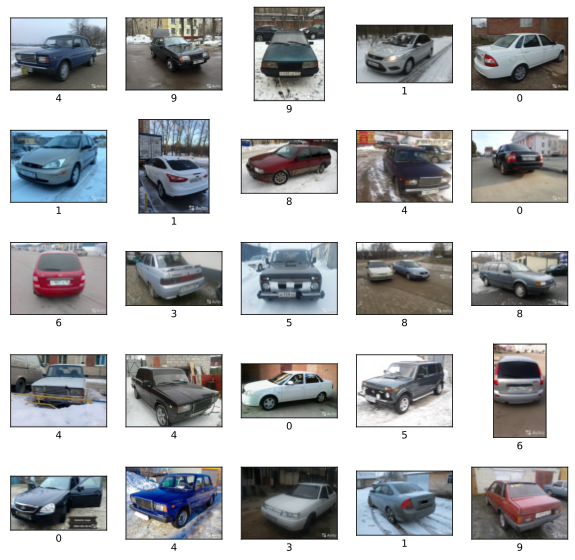

In [62]:
# Let's look at some random images
plt.figure(figsize=(10,10))
for i in range(25):
    rnd_car = np.random.randint(0,(len(train_df)-1))
    car_cat = train_df.iloc[rnd_car]['Category']
    car_file = train_df.iloc[rnd_car]['Id']
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = PIL.Image.open(PATH+'train/'+str(car_cat)+'/'+car_file)
    plt.imshow(image)
    plt.xlabel(car_cat)
plt.show()

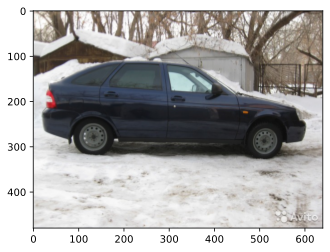

(640, 480)

In [63]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Image pre-processing block

In [64]:
## image augmentation settings (using built-in albumentations library)
# from ImageDataAugmentor.image_data_augmentor import *
# import albumentations

# AUGMENTATIONS = albumentations.Compose([
#     albumentations.Rotate(always_apply=False, p=1, limit=(-5, 5), interpolation=1, border_mode=0, value=(0, 0, 0), mask_value=None)
#     ,albumentations.HorizontalFlip(always_apply=False, p=0.5)
#     ,albumentations.Downscale(always_apply=False, p=1, scale_min=0.4, scale_max=0.6, interpolation=1)
#     #,albumentations.ElasticTransform(always_apply=False, p=0.25, alpha=0.6, sigma=70, alpha_affine=22, interpolation=3, border_mode=1, value=(0, 0, 0), mask_value=None, approximate=False)
#     ,albumentations.Blur(always_apply=False, p=1.0, blur_limit=(3, 7))
# ])

# train_datagen = ImageDataAugmentor(
#         rescale=1./255,
#         augment=AUGMENTATIONS,
#         validation_split=VAL_SPLIT, # set validation split
#         preprocess_input=None)

# test_datagen = ImageDataAugmentor(rescale=1. / 255)

# image augmentation settings (using built-in ImageDataGenerator)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [65]:
# generating augmented images from existing images
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Пример картинок из train_generator


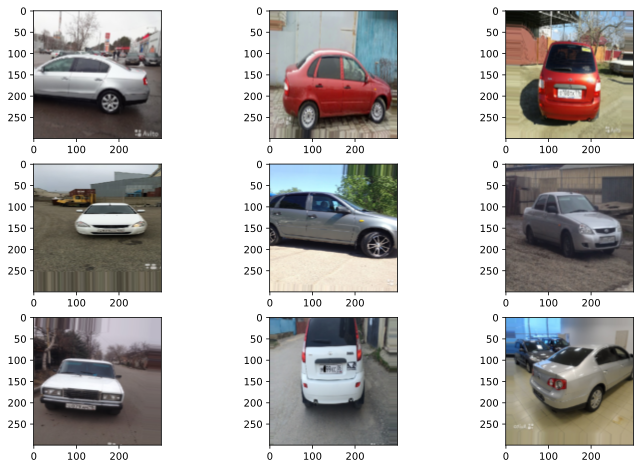

In [66]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

# Base model training

In [67]:
clear_session()

In [68]:
#base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape = input_shape)

In [69]:
base_model.summary()

Model: "efficientnetb6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [70]:
# attaching a new head
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [71]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [72]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
stop_learning = EarlyStopping(patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, min_lr=0.0000001, verbose=1, mode='auto')
callbacks_list = [checkpoint, stop_learning, reduce_lr]

In [73]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
827/827 [==============================] - 802s 940ms/step - loss: 1.4917 - accuracy: 0.5232 - val_loss: 0.3303 - val_accuracy: 0.8832

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 774s 936ms/step - loss: 0.2826 - accuracy: 0.8985 - val_loss: 0.2946 - val_accuracy: 0.8982

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 772s 933ms/step - loss: 0.1687 - accuracy: 0.9396 - val_loss: 0.1880 - val_accuracy: 0.9399

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 774s 935ms/step - loss: 0.1370 - accuracy: 0.9496 - val_loss: 2.4708 - val_accuracy: 0.1043

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 774s 935ms/step - loss: 0.1004 - accuracy: 0.9627 - val_loss: 0.5478 - val_accuracy: 0.8248

Epoch 00005: saving model to best_model.hdf5

Epoch 00005: ReduceLROnPlateau reducing lear

In [74]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [75]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


146/146 [==============================] - 57s 387ms/step - loss: 0.1342 - accuracy: 0.9618
Accuracy: 96.18%


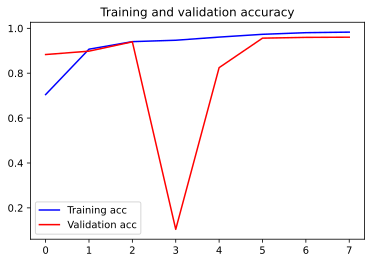

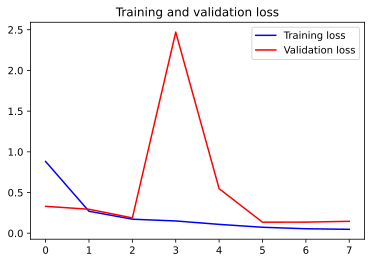

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [77]:
test_sub_generator.samples

6675

In [78]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


418/418 [==============================] - 68s 156ms/step


In [79]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [80]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


# Results

This is the last iteration of all. The best result was achieved using a model based on EfficientNetB6 with increased image size (300), batch size 16, number of epoch 8. Result on Kaggle: 0.96659. I believe that a strong base model (EfficientNetB6) as well as image augmentation techniques and ReduceLROnPlateau callback made this result possible. In fact, it looks like ReduceLROnPlateau saved the model from overfitting at epochs 3 and 4. Also, I am glad that EfficientNetB6 didn't throw an OOM error with image size 300.

Previous attempts were made with different settings and proved to be worse than the current result:
1) With the model based on Xception, image size 224, batch size 64, 10 epochs and no batch normalization I managed to achieve 0.94486 on Kaggle.

2) All the attempts to train a model based on EfficientNetB6 with batch size 64 and 32 failed because of OOM error.

What could have been done better:
1) I didn't use fine-tuning techniques apart from transfer learning. I guess the result could be better if I performed the learning iteratively while freezing some layers at each iteration.

2) Even though I tried using albumenation library for image augmentation, it didn't give any useful results. Maybe I simply didn't find a right augmentation technique from this library.

3) I didn't experiment with the head much (apart from adding batch normalization).
